# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 09 - Classificação de Imagens de Satélite usando o Pytorch

## Pytorch

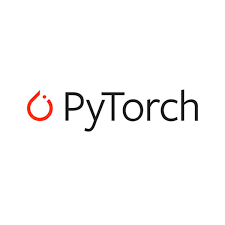

O PyTorch é uma biblioteca Python de aprendizado de máquina de código aberto usada para implementações de aprendizado profundo, como visão computacional (usando TorchVision) e processamento de linguagem natural. Essa biblioteca foi desenvolvida pelo laboratório de pesquisa de IA do Facebook (FAIR) em 2016 e, desde então, é adotada nos campos da ciência de dados e ML.

O PyTorch torna o aprendizado de máquina intuitivo para aqueles que já estão familiarizados com Python e tem ótimos recursos como suporte OOP e gráficos de computação dinâmica.

Junto com a construção de redes neurais profundas, o PyTorch também é ótimo para cálculos matemáticos complexos por causa de sua aceleração de GPU. Esse recurso permite que o PyTorch use a GPU do seu computador para acelerar enormemente os cálculos.

Essa combinação de recursos exclusivos e a simplicidade incomparável do PyTorch o torna uma das bibliotecas de aprendizado profundo mais populares, competindo apenas com o TensorFlow pelo primeiro lugar.

## PyTorch vs. TensorFlow

Houve muito mais diferenças em PyTorch vs TensorFlow quando eles foram lançados pela primeira vez. Muitas dessas inconsistências foram eliminadas. No entanto, ainda há algumas disparidades que valem a pena examinar:

- API

  As limitações da API do TensorFlow foram a primeira coisa que levou à criação de PyTorch em primeiro lugar. Desde então, a API do TensorFlow foi atualizada um pouco, mas PyTorch foi criado especificamente para portar uma biblioteca de aprendizado de máquina no ambiente Python.

- Gráfico de Computação

  Os gráficos de computação são algumas das diferenças mais significativas entre PyTorch e TensorFlow.

  TensorFlow usa gráficos de computação estáticos para alocar recursos. Ele cria um gráfico para a série de cálculos que você deseja executar. Quando os recursos estão sendo alocados, ele usa dados de espaço reservado para fazer seus cálculos.

  Os dados são então conectados, depois do fato.

  PyTorch usa gráficos de computação dinâmica, por outro lado. Isso significa que os cálculos são executados depois que cada linha de código é concluída.

  Os gráficos de computação estática são mais fáceis nos processadores. Eles são um problema para depurar, no entanto, o que torna o cálculo dinâmico preferível para muitas aplicações.

- Computação Distribuída

  Em seus primeiros dias, a execução de TensorFlow em vários dispositivos ou plataformas era proibitivamente difícil. Você teria que ajustar o TensorFlow manualmente para que ele seja executado sem problemas em aplicativos descentralizados.

  PyTorch não tem as mesmas limitações. Como acontece com muitas outras questões que discutimos, o TensorFlow resolveu muitas dessas questões nos anos seguintes. Para esse problema específico, TensorFlow criou Unidades de Programação Tensor (TPU).

  As TPUs são ainda mais rápidas do que as GPUs e agora são amplamente utilizadas e disponíveis. PyTorch não é tão adepto de manusear TPUs, mas isso pode ser tratado usando plugins de terceiros como XLA.

Vamos aplicar uma rede convolucional usando o PyTorch para classificar imagens de satélite:

In [ ]:
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import keras as k
import torchvision.models as models
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from keras.optimizers import Adam, Adamax
import gc
import matplotlib.pyplot as plt

gc.collect()

torch.cuda.empty_cache()

import seaborn as sns
import matplotlib.pyplot as plt

Depois de importar as funções e modulos da bibliotecas que vamos usar, Instânciamos a Resnet para aplicarmos aqui:

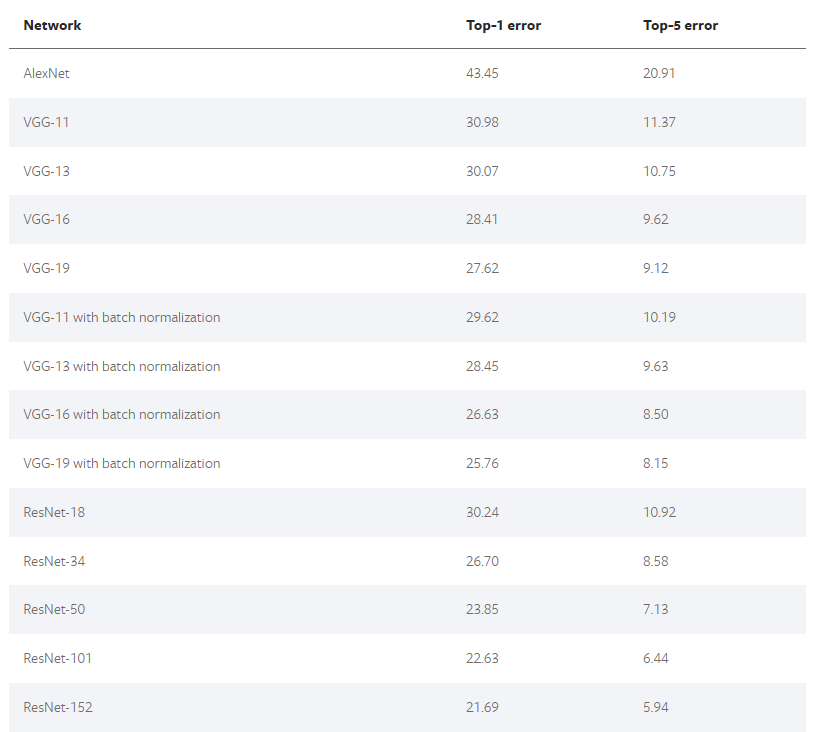

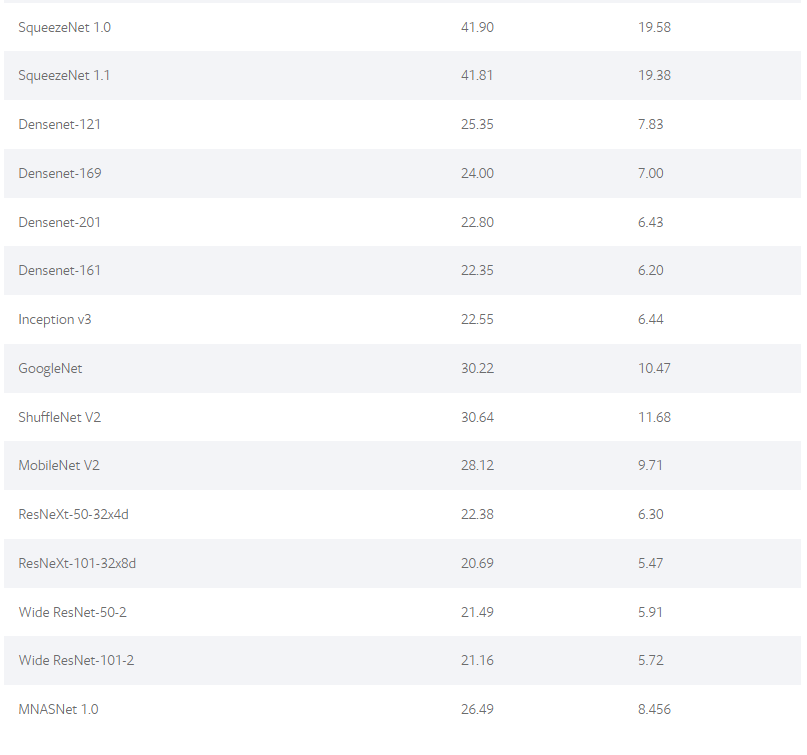

In [ ]:
resnet = models.resnet18(pretrained=True)
print(resnet)
print(resnet.fc.in_features)
print(resnet.fc.out_features)
# check if CUDA is available
use_cuda = torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 275MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Vamos também, acessar os dados no Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Agora, importamos as imagens de cada classe que estão separadas por pasta, no diretório 'data'. Aplicamos também o aumento de dados para termos mais amostras:

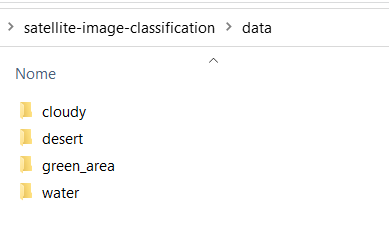

In [ ]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder('/content/drive/MyDrive/Datasets/satellite-image-classification/data', transform=transform)
print('Classes: ', dataset.classes)

Classes:  ['cloudy', 'desert', 'green_area', 'water']


No codigo anterior aplicamos um resize na imagens:

In [ ]:
dataset[0][0].shape

torch.Size([3, 256, 256])

A proxima etapa é verificar a quantidade de amostras por classe:

In [ ]:
from collections import Counter
value_counts = dict(Counter(dataset.targets))

In [ ]:
value_counts = dict(zip(dataset.classes, value_counts.values()))

print(value_counts)

{'cloudy': 1500, 'desert': 1131, 'green_area': 1500, 'water': 1500}


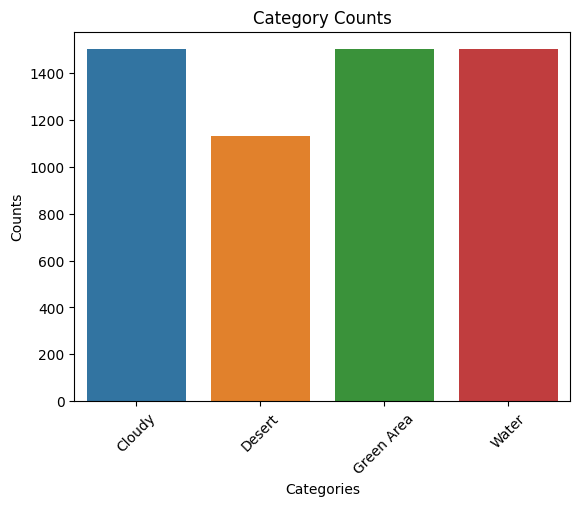

In [ ]:
sns.barplot(x=list(value_counts.keys()), y= list(value_counts.values()))
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Category Counts')
plt.xticks(range(4),labels = ["Cloudy", "Desert", "Green Area", "Water"], rotation = 45)
plt.show()

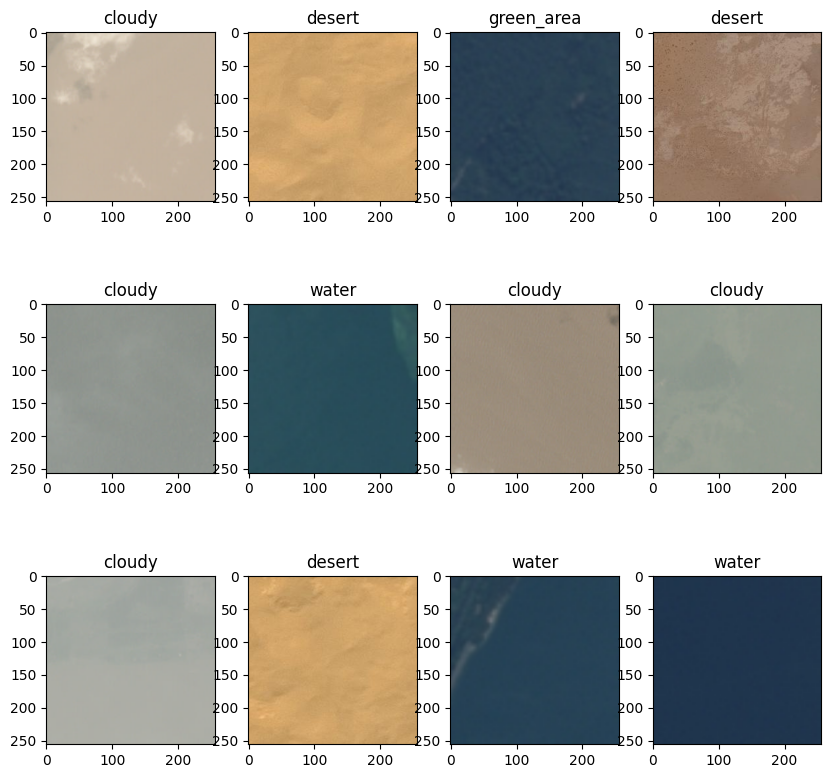

In [ ]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns * rows + 1):
    idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[idx]
    class_name = dataset.classes[label]
    fig.add_subplot(rows, columns, i)
    plt.title(class_name)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

Então, dividimos os dados em treinamento , validação e teste:

In [ ]:
train_data, val_data,test_data = torch.utils.data.random_split(dataset, [3950, 1120,561])
print('Num training images: ', len(train_data))
print('Num test images: ', len(val_data))
print('Num test images: ', len(test_data))

Num training images:  3950
Num test images:  1120
Num test images:  561


Vamos criar dataloaders para cada um dos sets:

In [ ]:
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

Aqui, é hora de configurar a entrada e a saída da rede com o tamanho das imagens e a quantidade de classes:

In [ ]:
n_inputs = resnet.fc.in_features
last_layer = nn.Linear(n_inputs, 4)
resnet.fc = last_layer
print(resnet.fc.out_features)

4


Por fim podemos configurar também o otimizador e a loss que vamos usar:

In [ ]:
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Agora podemos aplicar o treinamento e a validação por 10 épocas, e verificar os valores de Loss e acurácia.

In [ ]:
train_accuracies = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    resnet.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train

    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    resnet.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet(images)
            loss = criterion(outputs, labels)

            # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test

    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")

100%|██████████| 124/124 [17:28<00:00,  8.45s/it]


Epoch 1/10 - Train Loss: 1.1273 - Train Acc: 0.5813 - Test Loss: 0.7302 - Test Acc: 0.8877


100%|██████████| 124/124 [00:12<00:00, 10.29it/s]


Epoch 2/10 - Train Loss: 0.6160 - Train Acc: 0.9213 - Test Loss: 0.4537 - Test Acc: 0.9608


100%|██████████| 124/124 [00:11<00:00, 10.34it/s]


Epoch 3/10 - Train Loss: 0.4321 - Train Acc: 0.9473 - Test Loss: 0.3325 - Test Acc: 0.9697


100%|██████████| 124/124 [00:12<00:00, 10.32it/s]


Epoch 4/10 - Train Loss: 0.3469 - Train Acc: 0.9509 - Test Loss: 0.2796 - Test Acc: 0.9804


100%|██████████| 124/124 [00:11<00:00, 10.35it/s]


Epoch 5/10 - Train Loss: 0.2897 - Train Acc: 0.9570 - Test Loss: 0.2406 - Test Acc: 0.9768


100%|██████████| 124/124 [00:11<00:00, 10.34it/s]


Epoch 6/10 - Train Loss: 0.2454 - Train Acc: 0.9696 - Test Loss: 0.1894 - Test Acc: 0.9840


100%|██████████| 124/124 [00:11<00:00, 10.37it/s]


Epoch 7/10 - Train Loss: 0.2207 - Train Acc: 0.9658 - Test Loss: 0.1739 - Test Acc: 0.9840


100%|██████████| 124/124 [00:12<00:00, 10.31it/s]


Epoch 8/10 - Train Loss: 0.2107 - Train Acc: 0.9648 - Test Loss: 0.1640 - Test Acc: 0.9893


100%|██████████| 124/124 [00:12<00:00, 10.14it/s]


Epoch 9/10 - Train Loss: 0.1902 - Train Acc: 0.9716 - Test Loss: 0.1439 - Test Acc: 0.9875


100%|██████████| 124/124 [00:11<00:00, 10.37it/s]


Epoch 10/10 - Train Loss: 0.1848 - Train Acc: 0.9668 - Test Loss: 0.1300 - Test Acc: 0.9875


 Vamos plotar o gráfico das curvas de loss e acurácia:

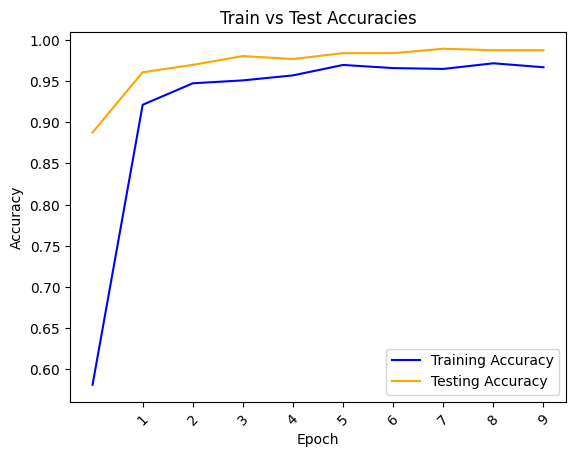

In [ ]:
sns.lineplot(x = range(10), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(10), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,10), rotation = 45)
plt.yticks(label = range(1,100,10))
plt.legend()
plt.show()

Geramos a matriz de confusão para ver os acertos e erros:

In [ ]:
from sklearn.metrics import confusion_matrix

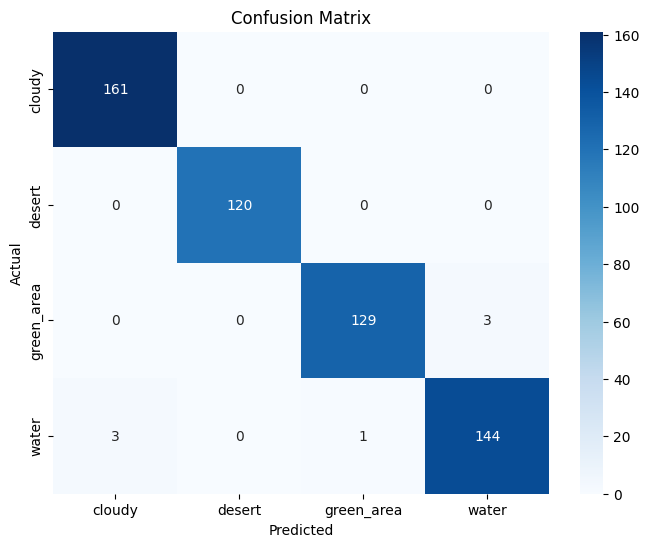

In [ ]:
cm = confusion_matrix(all_targets, all_predictions)
labels = dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Com o modelo validado podemos aplica-lo em uma imagem e ver como será o resultado da classificação:

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    images = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(images)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Text(0.5, 1.0, 'Label: water, Predicted: water')

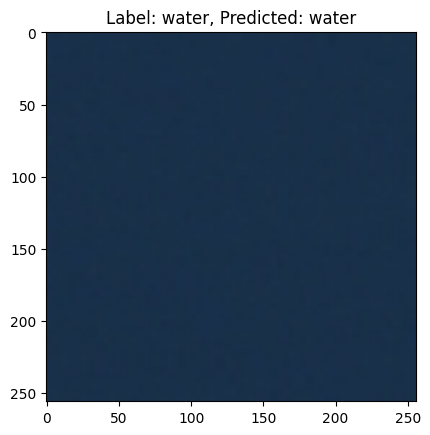

In [ ]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
plt.title('Label: ' + dataset.classes[label] + ', Predicted: '+ predict_image(img, resnet))